<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Pytorch/Pytorch_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Winequality-red

https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Prepare data

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Data/winequality-red.csv")
print(df.shape)
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


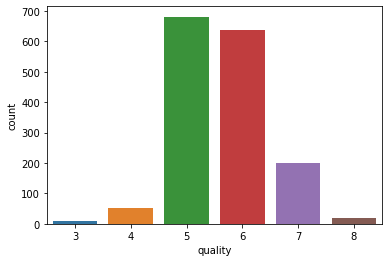

In [ ]:
sns.countplot(x = 'quality', data=df)

In [ ]:
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

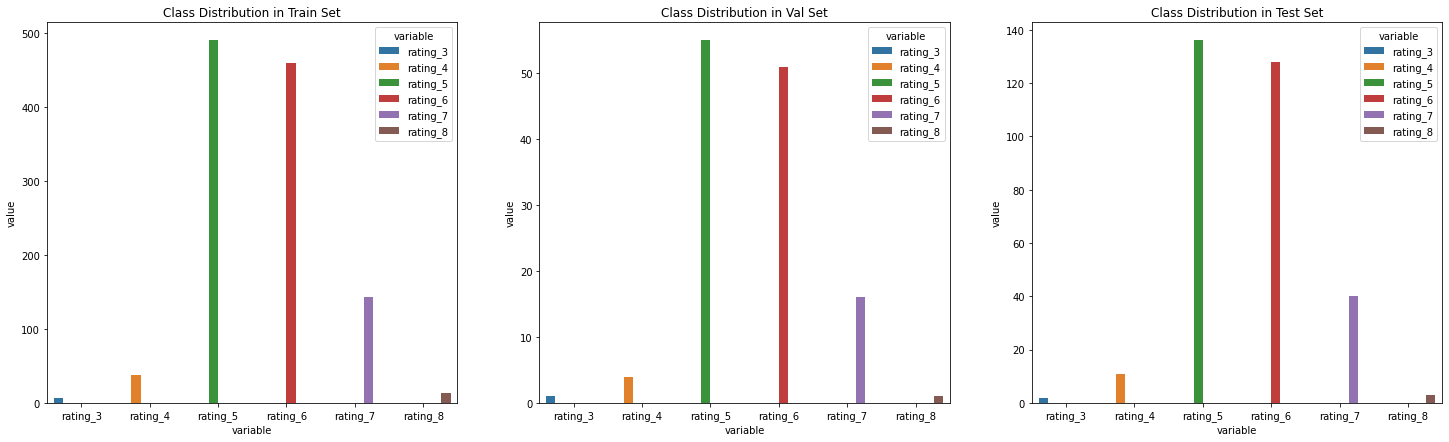

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

## Neural Network

In [ ]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

Weighted Sampling

Because there’s a class imbalance, we use stratified split to create our train, validation, and test sets.

While it helps, it still does not ensure that each mini-batch of our model see’s all our classes. We need to over-sample the classes with less number of values. To do that, we use the WeightedRandomSampler.

First, we obtain a list called target_list which contains all our outputs. This list is then converted to a tensor and shuffled.

In [ ]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]
print(target_list.shape)
target_list

torch.Size([1151])


tensor([0, 3, 3,  ..., 4, 5, 3])

Then, we obtain the count of all classes in our training set. We use the reciprocal of each count to obtain it’s weight. Now that we’ve calculated the weights for each class, we can proceed.

In [ ]:
get_class_distribution(y_train).values()

dict_values([7, 38, 490, 459, 143, 14])

In [ ]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])


WeightedRandomSampler expects a weight for each sample. We do that using as follows.

In [ ]:
class_weights_all = class_weights[target_list]
print(class_weights_all.shape)
class_weights_all

torch.Size([1151])


tensor([0.1429, 0.0022, 0.0022,  ..., 0.0070, 0.0714, 0.0022])

Finally, let’s initialize our WeightedRandomSampler. We’ll call this in our dataloader below.

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
weighted_sampler

Model Parameters

Before we proceed any further, let’s define a few parameters that we’ll use down the line.

In [ ]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

Dataloader

Let’s now initialize our dataloaders.

For train_dataloader we’ll use batch_size = 64 and pass our sampler to it. Note that we’re not using shuffle=True in our train_dataloader because we’re already using a sampler. These two are mutually exclusive.

For test_dataloader and val_dataloader we’ll use batch_size = 1 .

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Define Neural Net Architecture

Let’s define a simple 3-layer feed-forward network with dropout and batch-norm.

In [ ]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Initialize the model, optimizer, and loss function. Transfer the model to GPU. We’re using the nn.CrossEntropyLoss because this is a multiclass classification problem. We don’t have to manually apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us. However, we need to apply log_softmax for our validation and testing.

In [ ]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Train the model

Before we start our training, let’s define a function to calculate accuracy per epoch.
This function takes y_pred and y_test as input arguments. We then apply log_softmax to y_pred and extract the class which has a higher probability.
After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

We’ll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

In [ ]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.57527 | Val Loss: 1.39722 | Train Acc: 26.389| Val Acc: 49.219
Epoch 002: | Train Loss: 1.15340 | Val Loss: 1.34056 | Train Acc: 48.611| Val Acc: 46.875
Epoch 003: | Train Loss: 1.19870 | Val Loss: 1.43364 | Train Acc: 66.667| Val Acc: 41.406
Epoch 004: | Train Loss: 1.10224 | Val Loss: 1.29152 | Train Acc: 65.278| Val Acc: 47.656
Epoch 005: | Train Loss: 0.96598 | Val Loss: 1.24683 | Train Acc: 69.444| Val Acc: 47.656
Epoch 006: | Train Loss: 0.91571 | Val Loss: 1.33470 | Train Acc: 86.111| Val Acc: 49.219
Epoch 007: | Train Loss: 0.87877 | Val Loss: 1.31213 | Train Acc: 83.333| Val Acc: 46.875
Epoch 008: | Train Loss: 0.89386 | Val Loss: 1.34821 | Train Acc: 79.167| Val Acc: 43.750
Epoch 009: | Train Loss: 0.90446 | Val Loss: 1.24698 | Train Acc: 86.111| Val Acc: 51.562
Epoch 010: | Train Loss: 0.81936 | Val Loss: 1.30515 | Train Acc: 86.111| Val Acc: 43.750
Epoch 011: | Train Loss: 0.74114 | Val Loss: 1.23156 | Train Acc: 86.111| Val Acc: 50.781
Epoch 012:

You can see we’ve put a model.train() at the before the loop. model.train() tells PyTorch that you’re in training mode.

Well, why do we need to do that? If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation (for example; not use dropout during evaluation), you need to tell PyTorch to act accordingly.

Similarly, we’ll call model.eval() when we test our model. We’ll see that below.

Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we’ll print out the loss/accuracy and reset it back to 0.
Then we have another for-loop. This for-loop is used to get our data in batches from the train_loader.

We do optimizer.zero_grad() before we make any predictions. Since the backward() function accumulates gradients, we need to set it to 0 manually per mini-batch.

From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform back-propagation using loss.backward() and optimizer.step() .

Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch. We add up all the losses/accuracies for each mini-batch and finally divide it by the number of mini-batches ie. length of train_loader to obtain the average loss/accuracy per epoch.

The procedure we follow for training is the exact same for validation except for the fact that we wrap it up in torch.no_grad and not perform any back-propagation. torch.no_grad() tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.

Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and loss_stats dictionaries.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

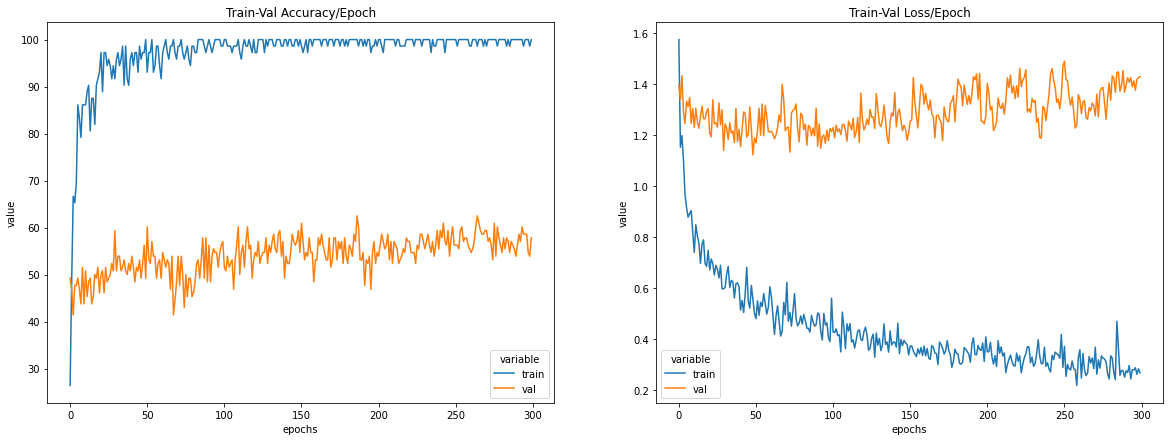

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Test the model

After training is done, we need to test how our model fared. Note that we’ve used model.eval() before we run our testing code. To tell PyTorch that we do not want to perform back-propagation during inference, we use torch.no_grad(), just like we did it for the validation loop above.
We start by defining a list that will hold our predictions. Then we loop through our batches using the test_loader. For each batch —
- We move our input mini-batch to GPU.
- We make the predictions using our trained model.
- Apply log_softmax activation to the predictions and pick the index of highest probability.
- Move the batch to the GPU from the CPU.
- Convert the tensor to a numpy object and append it to our list.
- Flatten out the list so that we can use it as an input to confusion_matrix and classification_report.

`


In [ ]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

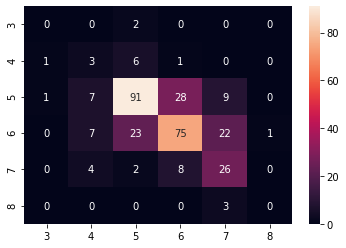

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.27      0.19        11
           2       0.73      0.67      0.70       136
           3       0.67      0.59      0.62       128
           4       0.43      0.65      0.52        40
           5       0.00      0.00      0.00         3

    accuracy                           0.61       320
   macro avg       0.33      0.36      0.34       320
weighted avg       0.64      0.61      0.62       320

